In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
from tqdm.autonotebook import tqdm
from scipy import signal

/srv/conda/envs/notebook/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']
experiment_ids1 = ['historical']

# Seasons to process
seasons = ['all','DJF','JJA']

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])


In [3]:
# Read data locations
df = pd.read_csv('https://storage.googleapis.com/pangeo-cmip6/pangeo-cmip6-zarr-consolidated-stores.csv')

In [4]:
# Subset to monthly precipitation (let's just look at one run per model for now)
df_mon_pr = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'pr')
                 & (df.member_id == "r1i1p1f1"))])

In [5]:
# Get names of all the models in the subset
pr_source_ids = []
for name, group in df_mon_pr.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        pr_source_ids.append(name)

In [6]:
# Subset to monthly tas (let's just look at one run per model for now)
df_mon_tas = (df[((df.table_id == 'Amon') 
                 & (df.variable_id == 'tas')
                 & (df.member_id == "r1i1p1f1"))])

In [7]:
# Get names of all the models in the subset
tas_source_ids = []
for name, group in df_mon_tas.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids]):
        tas_source_ids.append(name)

In [8]:
# Get names of all the models in the subset
df_areacella = (df[((df.table_id == 'fx') 
                 & (df.variable_id == 'areacella')
                 & (df.member_id == "r1i1p1f1"))])

areacella_source_ids = []
for name, group in df_areacella.groupby('source_id'):
    if all([expt in group.experiment_id.values
            for expt in experiment_ids1]):
        areacella_source_ids.append(name)
areacella_source_ids

['CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'E3SM-1-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MCM-UA-1-0',
 'MIROC6',
 'MRI-ESM2-0',
 'SAM0-UNICON']

In [9]:
tas_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [10]:
pr_source_ids

['BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-WACCM',
 'CanESM5',
 'FGOALS-g3',
 'GFDL-ESM4',
 'IPSL-CM6A-LR',
 'MIROC6',
 'MRI-ESM2-0']

In [11]:
source_ids=list(set(tas_source_ids).intersection(pr_source_ids))
source_ids

['GFDL-ESM4',
 'BCC-ESM1',
 'BCC-CSM2-MR',
 'MIROC6',
 'MRI-ESM2-0',
 'CESM2-WACCM',
 'CESM2',
 'CanESM5',
 'IPSL-CM6A-LR',
 'CAMS-CSM1-0']

In [12]:
source_ids_areacella=list(set(tas_source_ids).intersection(pr_source_ids).intersection(areacella_source_ids))
source_ids_areacella

['GFDL-ESM4',
 'MRI-ESM2-0',
 'MIROC6',
 'CESM2-WACCM',
 'CESM2',
 'CanESM5',
 'IPSL-CM6A-LR']

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    if weights_in is not None:
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
    else:
        # Area weighting
        latr = np.deg2rad(data_tmp['hist'].lat)
        # Use the cosine of the converted latitudes as weights for the average
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


#     return(outp)
    return(dtasG)

In [15]:

tdata = {}

times = []
for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])
        
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        tdata[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            dtasG = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                                   seas = 'all', weights_in=ds_areacella)
                
            times.append(xr.Dataset( {mod_name: ([ 'time'],  np.atleast_1d(dtasG))},
                              coords = { 'time': ('time',[int(time_slice[0])])}))

            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")
    
temp_da = xr.combine_by_coords(times)




Starting GFDL-ESM4

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
GFDL-ESM4 processed!


Starting BCC-ESM1

Begin processing time slice 1991-2020
 processed!
1991-2020 processed!
Begin processing time slice 2001-2030
 processed!
2001-2030 processed!
Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin process

In [16]:
temp_da.to_dataframe()

,BCC-CSM2-MR,BCC-ESM1,CAMS-CSM1-0,CESM2,CESM2-WACCM,CanESM5,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
time,,,,,,,,,,
1991,0.666351,0.802085,0.350626,0.718262,0.768097,0.905243,0.589783,0.716827,0.376282,0.760193
2001,0.791522,0.950498,0.492920,0.917542,0.877380,1.198212,0.695282,0.845734,0.547302,0.897766
2011,0.964405,1.080176,0.585576,1.094421,1.007812,1.438416,0.812836,1.021454,0.697571,1.023926
2021,1.241890,1.282089,0.772982,1.337646,1.271332,1.863525,1.021606,1.346252,0.924072,1.267822
2031,1.599642,NaN,0.993943,1.657043,1.642242,2.394562,1.295166,1.789948,1.235840,1.614258
2041,1.969405,NaN,1.272332,2.027405,2.098663,2.996094,1.631042,2.248840,1.533264,1.980377
2051,2.325534,NaN,1.531312,2.485107,2.548523,3.578979,2.001801,2.722992,1.861328,2.343811
2061,2.711012,NaN,1.834118,3.025238,3.027191,4.184479,2.398132,3.222717,2.143311,2.689697
2071,3.085562,NaN,2.101574,3.541107,3.494812,4.786499,2.761627,3.826843,2.475281,3.042175


In [17]:
temp_da.to_dataframe().to_csv('tresults.csv')

In [18]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,BCC-CSM2-MR,BCC-ESM1,CAMS-CSM1-0,CESM2,CESM2-WACCM,CanESM5,GFDL-ESM4,IPSL-CM6A-LR,MIROC6,MRI-ESM2-0
time,,,,,,,,,,
1991,0.666351,0.802085,0.350626,0.718262,0.768097,0.905243,0.589783,0.716827,0.376282,0.760193
2001,0.791522,0.950498,0.492920,0.917542,0.877380,1.198212,0.695282,0.845734,0.547302,0.897766
2011,0.964405,1.080176,0.585576,1.094421,1.007812,1.438416,0.812836,1.021454,0.697571,1.023926
2021,1.241890,1.282089,0.772982,1.337646,1.271332,1.863525,1.021606,1.346252,0.924072,1.267822
2031,1.599642,NaN,0.993943,1.657044,1.642242,2.394562,1.295166,1.789947,1.235840,1.614258
2041,1.969405,NaN,1.272332,2.027405,2.098663,2.996094,1.631042,2.248840,1.533264,1.980377
2051,2.325534,NaN,1.531312,2.485107,2.548523,3.578979,2.001801,2.722992,1.861328,2.343811
2061,2.711012,NaN,1.834118,3.025238,3.027191,4.184479,2.398132,3.222717,2.143311,2.689697
2071,3.085562,NaN,2.101574,3.541107,3.494812,4.786499,2.761627,3.826843,2.475281,3.042175


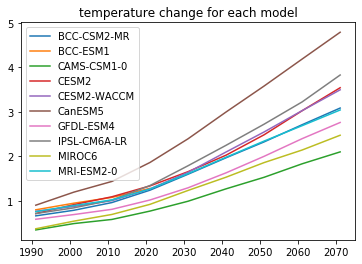

In [19]:
plt.plot(tresults_new)
plt.title('temperature change for each model')
plt.legend(tresults_new.columns)

In [20]:
tresults_dict=tresults_new.to_dict()

In [21]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

# PRECIP

In [22]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):

    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    # Calculate variance
    var_hist = sd_hist ** 2
    var_futr = sd_futr ** 2
    

    # Area averaging #
    if weights_in is not None:
        print('Using areacella')
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
        var_histG = np.average(var_hist.pr,weights=weights)
        var_futrG = np.average(var_futr.pr,weights=weights)
    else:
        print('Areacella unavailable; ')
        ## if areacella is not available
        ## Use the cosine of the converted latitudes as weights for the average
        latr = np.deg2rad(data_tmp['hist'].lat)
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        var_histG = np.average(var_hist.mean("lon").pr,weights=weights)
        var_futrG = np.average(var_futr.mean("lon").pr,weights=weights)
        
    sd_histG = np.sqrt(var_histG)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)
    
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    dmuG = xr.DataArray(dmuG, coords=[], dims=[]).rename('dmuG')
    dsdG = xr.DataArray(dsdG, coords=[], dims=[]).rename('dsdG')

#     outp = xr.DataArray(
#         data_vars = {'mu_hist': mu_hist,
#                      'mu_futr': mu_futr,
#                      #'dmu':     dmu,
#                      'dmuG':    ([],dmuG),
#                      'sd_hist': sd_hist.pr,
#                      'sd_futr': sd_futr.pr,
#                      #'dsd':     dsd.pr,
#                      'dsdG':    ([],dsdG)},
#         #coords={'lon':            (['lon'],results_tmp['hist'].lon),
#         #        'lat':             (['lat'],results_tmp['hist'].lat)}
#         )


    return(mu_hist, mu_futr, dmuG,sd_hist.pr, sd_futr.pr, dsdG)

In [23]:
seasons

['all', 'DJF', 'JJA']

In [24]:

data = {}
models = []

for mod_name in tqdm(source_ids[0:2]):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        data[mod_name] = {}
        
        times = []
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
           # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            

## implement this later, for now just do DJF 
            seasons_loop = []
            for seas in seasons:
                # Calculate means, sds,...
                mu_hist, mu_futr, dmuG,sd_hist, sd_futr, dsdG= mean_var_calc(data[mod_name]['t'+time_slice[0]],
                                                                           seas, weights_in = ds_areacella)
                # concatenate dataarrays
                das = [mu_hist.rename('mu_hist'),
                       mu_futr.rename('mu_futr'),
                       dmuG,
                       sd_hist.rename('sd_hist'), 
                       sd_futr.rename('sd_futr'), dsdG]
                das_expanded = [da.expand_dims(['model_name', 'time', 'season']) for da in das]
                dasb = xr.merge(das_expanded)
                dasb.coords['model_name'] = 'model_name', [mod_name]
                dasb.coords['time'] = 'time', [int(time_slice[0])]
                dasb.coords['season'] = 'season', [seas]
                seasons_loop.append(dasb)
                #print(seas+' processed!')
            times.append(seasons_loop)    
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
        models.append(times)
    #except:
    #    print(mod_name+"broken")
    
    

temp_dapr = xr.combine_nested(models, concat_dim=['model_name','time', 'season'])
temp_dapr




Starting GFDL-ESM4

Begin processing time slice 1991-2020
Using areacella
Using areacella
Using areacella
1991-2020 processed!
Begin processing time slice 2001-2030
Using areacella
Using areacella
Using areacella
2001-2030 processed!
Begin processing time slice 2011-2040
Using areacella
Using areacella
Using areacella
2011-2040 processed!
Begin processing time slice 2021-2050
Using areacella
Using areacella
Using areacella
2021-2050 processed!
Begin processing time slice 2031-2060
Using areacella
Using areacella
Using areacella
2031-2060 processed!
Begin processing time slice 2041-2070
Using areacella
Using areacella
Using areacella
2041-2070 processed!
Begin processing time slice 2051-2080
Using areacella
Using areacella
Using areacella
2051-2080 processed!
Begin processing time slice 2061-2090
Using areacella
Using areacella
Using areacella
2061-2090 processed!
Begin processing time slice 2071-2100
Using areacella
Using areacella
Using areacella
2071-2100 processed!
GFDL-ESM4 proce

ValueError: The supplied objects do not form a hypercube because sub-lists do not have consistent lengths along dimension0

In [ ]:
dsdG_djf = temp_dapr.sel(season='DJF')
dsdG_djf.to_dataframe()

In [ ]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results
#dsdG_jja=results.copy()
#dmuG_djf=results.copy()
#dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
#        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
#        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
#        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
    

In [ ]:
pd.DataFrame(dsdG_djf)

In [ ]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [ ]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

In [ ]:
dsdG_djf=dsdG_djf_new.to_dict()

In [ ]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [ ]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [ ]:
dsdG_djf_np

In [ ]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)